In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv("../data/raw/creditcard.csv")

# Basic info
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Understanding the shape

In [3]:
df.shape


(284807, 31)

Confirm Fraud Imbalance (CRITICAL)

In [4]:
df["Class"].value_counts()


Class
0    284315
1       492
Name: count, dtype: int64

In [5]:
df["Class"].value_counts(normalize=True) * 100


Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64

First Visualization (Simple but Powerful)

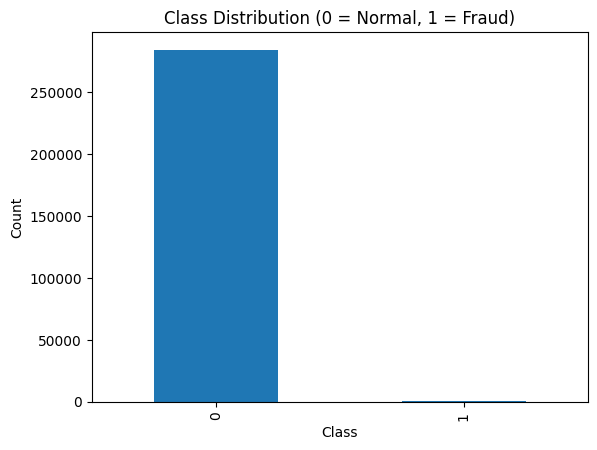

In [6]:
import matplotlib.pyplot as plt

df["Class"].value_counts().plot(kind="bar")
plt.title("Class Distribution (0 = Normal, 1 = Fraud)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


The dataset is extremely imbalanced, with fraudulent transactions representing less than 1% of total observations. This confirms that accuracy alone is not an appropriate evaluation metric and motivates the use of precision, recall, F1-score, and AUC-ROC in later stages.

Inspecting Time and Amount

In [7]:
df[["Time", "Amount"]].describe()


,Time,Amount
count,284807.000000,284807.000000
mean,94813.859575,88.349619
std,47488.145955,250.120109
min,0.000000,0.000000
25%,54201.500000,5.600000
50%,84692.000000,22.000000
75%,139320.500000,77.165000
max,172792.000000,25691.160000


Observation:

Amount max (huge outliers)

Time range (~2 days worth of seconds)

Insight: Time is relative, not absolute — important later.

Visualize Transaction Amounts Distribution

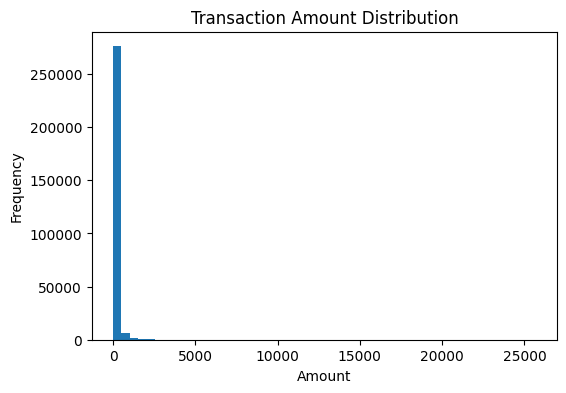

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(df["Amount"], bins=50)
plt.title("Transaction Amount Distribution")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()


Fraud insight:

Most transactions are small

Large transactions are rare but risky

Fraud vs Non-Fraud Amounts
Compare amounts

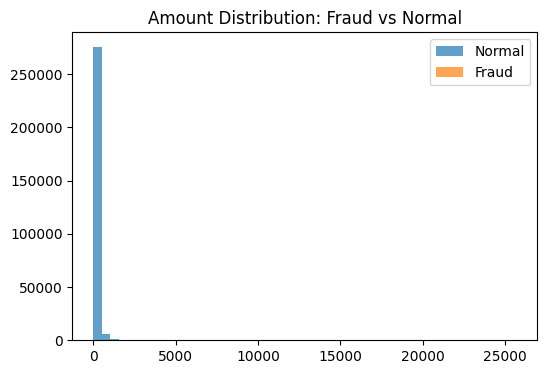

In [9]:
fraud = df[df["Class"] == 1]
normal = df[df["Class"] == 0]

plt.figure(figsize=(6,4))
plt.hist(normal["Amount"], bins=50, alpha=0.7, label="Normal")
plt.hist(fraud["Amount"], bins=50, alpha=0.7, label="Fraud")
plt.legend()
plt.title("Amount Distribution: Fraud vs Normal")
plt.show()


Time Patterns (Fraud Behavior)

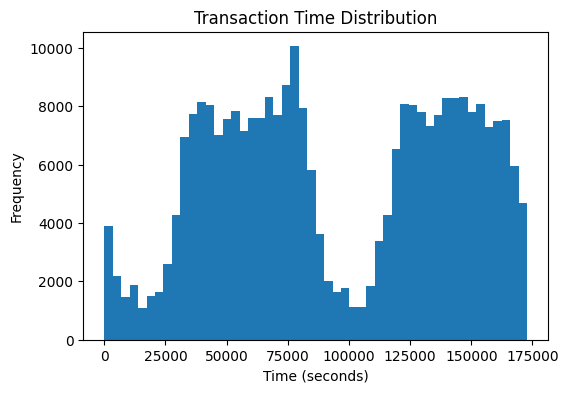

In [10]:
plt.figure(figsize=(6,4))
plt.hist(df["Time"], bins=50)
plt.title("Transaction Time Distribution")
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency")
plt.show()


Check for Missing Values

Even though this dataset is clean, you always check.
Missing values

In [11]:
df.isnull().sum()


Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Even when no missing values exist, verifying data integrity is a critical preprocessing step.

Create The FIRST Reusable Function (Important)


In [ ]:
from src.data.load_data import load_raw_data

df = load_raw_data("../data/raw/creditcard.csv")
df.head()


Transaction amounts are heavily right-skewed, with fraudulent transactions exhibiting different distribution patterns than normal ones. Time is a relative feature spanning approximately two days, indicating that temporal behavior rather than absolute timestamps must be leveraged for fraud detection.

In [15]:
import sys
sys.path.append("..")


In [16]:
from src.data.load_data import load_raw_data

df = load_raw_data("../data/raw/creditcard.csv")
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
